# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [9]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', delimiter=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', delimiter=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.shape

(891221, 366)

In [4]:
df = pd.DataFrame(azdias.isnull().sum() *100 / azdias.shape[0], index = azdias.columns, columns = ['value'])
df[df.value >= 30]

,value
ALTER_KIND1,90.904837
ALTER_KIND2,96.690047
ALTER_KIND3,99.307691
ALTER_KIND4,99.864792
EXTSEL992,73.399639
KK_KUNDENTYP,65.596749


In [5]:
cols_to_drop = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']

In [6]:
azdias.drop(cols_to_drop, axis = 1, inplace = True)

In [7]:
cols = azdias.columns
cols_int = cols.difference(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
                           'WOHNLAGE'])

In [10]:
for col in cols_int:
    print(col)
    print(azdias[col].dtype)
    start = time()
    azdias[col] = azdias[col].fillna(-9).astype('int')
    finish = time()
    print(col, finish - start)

AGER_TYP
int64
AGER_TYP 2.0204882621765137
AKT_DAT_KL
float64
AKT_DAT_KL 7.863877534866333
ALTERSKATEGORIE_FEIN
float64
ALTERSKATEGORIE_FEIN 5.209156513214111
ALTERSKATEGORIE_GROB
int64
ALTERSKATEGORIE_GROB 0.3156123161315918
ALTER_HH
float64
ALTER_HH 3.727185010910034
ANREDE_KZ
int64
ANREDE_KZ 0.3027317523956299
ANZ_HAUSHALTE_AKTIV
float64
ANZ_HAUSHALTE_AKTIV 3.805025339126587
ANZ_HH_TITEL
float64
ANZ_HH_TITEL 3.264129877090454
ANZ_KINDER
float64
ANZ_KINDER 3.247650384902954
ANZ_PERSONEN
float64
ANZ_PERSONEN 2.616001844406128
ANZ_STATISTISCHE_HAUSHALTE
float64
ANZ_STATISTISCHE_HAUSHALTE 2.5931928157806396
ANZ_TITEL
float64
ANZ_TITEL 2.0092613697052
ARBEIT
float64
ARBEIT 2.0477795600891113
BALLRAUM
float64
BALLRAUM 1.9320142269134521
CJT_GESAMTTYP
float64
CJT_GESAMTTYP 1.8949930667877197
CJT_KATALOGNUTZER
float64
CJT_KATALOGNUTZER 1.8500478267669678
CJT_TYP_1
float64
CJT_TYP_1 1.633481740951538
CJT_TYP_2
float64
CJT_TYP_2 1.7184033393859863
CJT_TYP_3
float64
CJT_TYP_3 1.654164075851440

In [11]:
feat_info = pd.read_csv('type_feat.csv')

In [12]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTER_HH,household,interval,[0]
2,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
3,ANREDE_KZ,person,categorical,"[-1,0]"
4,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]


In [13]:
import re
def to_list(text):
    
    matches = re.findall(r'[0-9-]+', text)
    #text.replace('[', '').replace(']', '').split(',')
    
    result = [-9]
    for i in matches:
        result.append(int(i))
    
    return result

In [14]:
feat_info['missing'] = feat_info['missing_or_unknown'].apply(to_list)

In [15]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing
0,AGER_TYP,person,categorical,"[-1,0]","[-9, -1, 0]"
1,ALTER_HH,household,interval,[0],"[-9, 0]"
2,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-9, -1, 0, 9]"
3,ANREDE_KZ,person,categorical,"[-1,0]","[-9, -1, 0]"
4,ANZ_HAUSHALTE_AKTIV,building,numeric,[0],"[-9, 0]"


In [16]:
cols = azdias.columns.tolist()

In [17]:
for i in range(feat_info.shape[0]):
    start = time()
    variable = feat_info.iloc[i, 0]
    liste = feat_info.iloc[i, 4]
    if variable in cols:
        azdias.loc[azdias[variable].isin(liste), variable] = np.NaN
        final = time()
        print(i, final - start)

0 276.00402188301086
1 90.6543972492218
2 90.1643590927124
3 92.16447329521179
4 91.29550790786743
5 93.09021520614624
6 102.35606741905212
7 102.43536376953125
8 106.68956899642944
9 103.77635836601257
11 10.357475519180298
12 0.7099342346191406
14 0.6921782493591309
15 102.2896785736084
16 106.12653064727783


KeyboardInterrupt: 

In [18]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,-9,NaN,-9,NaN,NaN,-9,NaN,-9,...,-9,-9,-9,-9,-9,-9,NaN,3,1.0,2.0
1,910220,NaN,9,NaN,21,11.0,0.0,0,2.0,12,...,4,8,11,10,3,9,4.0,5,2.0,1.0
2,910225,NaN,9,17.0,17,10.0,0.0,0,1.0,7,...,2,9,9,6,3,9,2.0,5,2.0,3.0
3,910226,2.0,1,13.0,13,1.0,0.0,0,0.0,2,...,0,7,10,11,-9,9,7.0,3,2.0,4.0
4,910241,NaN,1,20.0,14,3.0,0.0,0,4.0,3,...,2,3,5,4,2,9,3.0,4,1.0,3.0


In [5]:
azdias['AKT_DAT_KL'].dtype

dtype('float64')

In [15]:
azdias['new'] = azdias['W_KEIT_KIND_HH'].fillna(-9).astype(object).astype('int')

In [16]:
liste = [-1, 0]
liste2 = [-1, 0, -9]

In [4]:
from time import time

In [18]:
start = time()
azdias.loc[azdias['W_KEIT_KIND_HH'].isin(liste), 'W_KEIT_KIND_HH'] = np.NaN
final = time()
print(final - start)

2.1758382320404053


In [19]:
start2 = time()
azdias.loc[azdias['new'].isin(liste2), 'new'] = np.NaN
final2 = time()
print(final2 - start2)

0.31900644302368164


In [23]:
cols = azdias.columns
cols_int = cols.difference(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
                           'WOHNLAGE'])

#azdias[cols_int] = azdias[cols_int].fillna(-9).astype(object).astype('int')

In [24]:
for col in cols_int:
    print(col)
    print(azdias[col].dtype)
    start = time()
    azdias[col] = azdias[col].fillna(-9).astype('int')
    finish = time()
    print(col, finish - start)

AGER_TYP
int64
AGER_TYP 0.011150836944580078
AKT_DAT_KL
int64
AKT_DAT_KL 0.009683609008789062
ALTERSKATEGORIE_FEIN
int64
ALTERSKATEGORIE_FEIN 0.009340286254882812
ALTERSKATEGORIE_GROB
int64
ALTERSKATEGORIE_GROB 0.00897669792175293
ALTER_HH
int64
ALTER_HH 0.009610652923583984
ALTER_KIND1
int64
ALTER_KIND1 0.009464740753173828
ALTER_KIND2
int64
ALTER_KIND2 0.009799480438232422
ALTER_KIND3
int64
ALTER_KIND3 0.009782791137695312
ALTER_KIND4
int64
ALTER_KIND4 0.00896596908569336
ANREDE_KZ
int64
ANREDE_KZ 0.008293390274047852
ANZ_HAUSHALTE_AKTIV
int64
ANZ_HAUSHALTE_AKTIV 0.008541584014892578
ANZ_HH_TITEL
int64
ANZ_HH_TITEL 0.009038209915161133
ANZ_KINDER
int64
ANZ_KINDER 0.008759498596191406
ANZ_PERSONEN
int64
ANZ_PERSONEN 0.007615804672241211
ANZ_STATISTISCHE_HAUSHALTE
int64
ANZ_STATISTISCHE_HAUSHALTE 0.007967948913574219
ANZ_TITEL
int64
ANZ_TITEL 0.008618354797363281
ARBEIT
int64
ARBEIT 0.00801849365234375
BALLRAUM
int64
BALLRAUM 0.007430315017700195
CJT_GESAMTTYP
int64
CJT_GESAMTTYP 0.007

In [25]:
feat_info = pd.read_csv('type_feat.csv')

In [26]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTER_HH,household,interval,[0]
2,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
3,ANREDE_KZ,person,categorical,"[-1,0]"
4,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]


In [27]:
import re
def to_list(text):
    
    matches = re.findall(r'[0-9-]+', text)
    #text.replace('[', '').replace(']', '').split(',')
    
    result = [-9]
    for i in matches:
        result.append(int(i))
    
    return result

In [28]:
feat_info['missing'] = feat_info['missing_or_unknown'].apply(to_list)

In [29]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing
0,AGER_TYP,person,categorical,"[-1,0]","[-9, -1, 0]"
1,ALTER_HH,household,interval,[0],"[-9, 0]"
2,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-9, -1, 0, 9]"
3,ANREDE_KZ,person,categorical,"[-1,0]","[-9, -1, 0]"
4,ANZ_HAUSHALTE_AKTIV,building,numeric,[0],"[-9, 0]"


In [37]:
azdias['ANREDE_KZ'] = azdias['ANREDE_KZ'].replace(-9, np.nan)


In [39]:
azdias['CJT_GESAMTTYP'] = azdias['CJT_GESAMTTYP'].replace(-9, np.nan)

In [42]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,3,1,2
1,910220,-1,9,0,-9,-9,-9,-9,21,11,...,4,8,11,10,3,9,4,5,2,1
2,910225,-1,9,17,-9,-9,-9,-9,17,10,...,2,9,9,6,3,9,2,5,2,3
3,910226,2,1,13,-9,-9,-9,-9,13,1,...,0,7,10,11,-9,9,7,3,2,4
4,910241,-1,1,20,-9,-9,-9,-9,14,3,...,2,3,5,4,2,9,3,4,1,3


In [46]:
azdias.iloc[:, 1:].replace(to_replace = -9, value = np.nan, inplace = True)

In [50]:
azdias.loc[azdias['AKT_DAT_KL'] == -9, 'AKT_DAT_KL'] = np.nan

In [ ]:
azdias.iloc[:, 1:] = azdias.iloc[:, 1:].replace(-9, np.nan)

In [40]:
azdias['CJT_GESAMTTYP'].isnull().sum()

4854

In [38]:
azdias['ANREDE_KZ'].isnull().sum()

0

In [31]:
s = time()

azdias.loc[azdias['AGER_TYP'].isin([-9, -1, 0]), 'AGER_TYP'] = np.NaN

f = time()

print(f - s)

/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:349: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.values = np.delete(self.values, loc, 0)
/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:350: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.mgr_locs = self.mgr_locs.delete(loc)


63.03784894943237


In [32]:
azdias['AGER_TYP'].isnull().sum()

0

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.columns[azdias.columns.str.startswith('ALTER')]

Index(['ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'ALTERSKATEGORIE_GROB'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf0a401908>]], dtype=object)

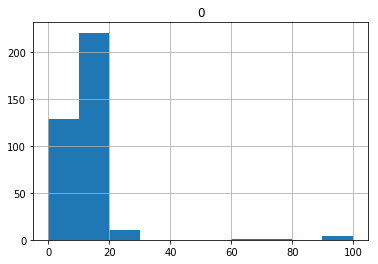

In [5]:
pd.DataFrame(azdias.isnull().sum() *100 / azdias.shape[0], index = azdias.columns).hist()

In [4]:
df = pd.DataFrame(azdias.isnull().sum() *100 / azdias.shape[0], index = azdias.columns, columns = ['value'])

In [5]:
df.head()

,value
LNR,0.000000
AGER_TYP,0.000000
AKT_DAT_KL,8.247000
ALTER_HH,8.247000
ALTER_KIND1,90.904837


In [6]:
df[df.value >= 30]

,value
ALTER_KIND1,90.904837
ALTER_KIND2,96.690047
ALTER_KIND3,99.307691
ALTER_KIND4,99.864792
EXTSEL992,73.399639
KK_KUNDENTYP,65.596749


In [7]:
cols_to_drop = df[df.value >= 30].index.tolist()

In [8]:
azdias.drop(cols_to_drop, axis = 1, inplace = True)

In [36]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1.0,2.0
1,910220,NaN,9.0,NaN,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2.0,1.0
2,910225,NaN,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2.0,3.0
3,910226,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2.0,4.0
4,910241,NaN,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1.0,3.0


In [37]:
cols = azdias.columns.tolist()
cols

['LNR',
 'AGER_TYP',
 'AKT_DAT_KL',
 'ALTER_HH',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_H

In [39]:
azdias['AGER_TYP'].dtype

dtype('float64')

In [ ]:
def convert_to_nan():

In [12]:
feat_info[feat_info.attribute.str.startswith('CAMEO')]

,attribute,information_level,type,missing_or_unknown
11,CAMEO_DEU_2015,microcell_rr4,categorical,[]
12,CAMEO_DEUG_2015,microcell_rr4,categorical,[-1]
13,CAMEO_DEUINTL_2015,household,mixed,[-1]
14,CAMEO_INTL_2015,microcell_rr4,mixed,[-1]


In [42]:
feat_info.iloc[11]

attribute             CAMEO_DEU_2015
information_level      microcell_rr4
type                     categorical
missing_or_unknown              [XX]
Name: 11, dtype: object

In [47]:
cols = azdias.columns.tolist()
cols[17]

'CJT_KATALOGNUTZER'

In [ ]:
azdias[azdias['CJT_TYP_1'] == np.NaN]

In [48]:
cols[18]

'CJT_TYP_1'

In [ ]:
azdias.to_csv(index = False)

In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
customers.shape

(191652, 369)

In [8]:
azdias[azdias.LNR == 143874]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
mailout_lnr = mailout_train.LNR.tolist()
azdias_lnr = azdias.LNR.tolist()

common_lnr = [i for i in mailout_lnr if i in azdias_lnr]

In [22]:
len(common_lnr)

0

In [4]:
mailout_train.columns.get_loc('RESPONSE')

364

In [7]:
mailout_train.iloc[:, 364].sum()

532

In [14]:
mailout_train.shape

(42962, 367)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')